<a href="https://colab.research.google.com/github/alierenc/di725-transformers-and-attention-based-deep-networks/blob/main/Assignment1/2.%20Training%20nanoGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# Mount Google Drive to access dataset and save models
drive.mount('/content/drive')

# Load the dataset
train_data_path = "/content/drive/MyDrive/DI725 - Transformers and Attention-based Deep Networks/Assignment 1/train_data.csv"
val_data_path = "/content/drive/MyDrive/DI725 - Transformers and Attention-based Deep Networks/Assignment 1/validation_data.csv"
test_data_path = "/content/drive/MyDrive/DI725 - Transformers and Attention-based Deep Networks/Assignment 1/test_data.csv"

!pip install wandb

import wandb
wandb.login()

!pip install torch numpy transformers datasets tiktoken wandb tqdm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aeren to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import AdamW
from torch import nn
from sklearn.preprocessing import LabelEncoder

import tiktoken


def load_data(csv_file):
    df = pd.read_csv(csv_file)
    texts = df['conversation'].tolist()
    labels = df['customer_sentiment'].tolist()
    return texts, labels

# Load train, validation, and test data
train_texts, train_labels = load_data(train_data_path)
val_texts, val_labels = load_data(val_data_path)
test_texts, test_labels = load_data(test_data_path)

# Initialize the GPT-2 tokenizer
enc = tiktoken.get_encoding("gpt2")

def tokenize(texts):
    return [enc.encode_ordinary(text) for text in texts]

# Tokenize the train, validation, and test datasets
train_ids = tokenize(train_texts)
val_ids = tokenize(val_texts)
test_ids = tokenize(test_texts)

# Padding or truncation to block_size
block_size = 1024
def pad_or_truncate(data, block_size):
    return [seq[:block_size] if len(seq) > block_size else seq + [0] * (block_size - len(seq)) for seq in data]

train_ids = pad_or_truncate(train_ids, block_size)
val_ids = pad_or_truncate(val_ids, block_size)
test_ids = pad_or_truncate(test_ids, block_size)

# Convert to tensors
train_ids = torch.tensor(train_ids)
val_ids = torch.tensor(val_ids)
test_ids = torch.tensor(test_ids)

# Convert labels to numerical format
label_encoder = LabelEncoder()

# Fit label encoder on the training labels and transform all labels
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)
test_labels = label_encoder.transform(test_labels)

# Convert labels to tensors
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

# Create DataLoader for train and validation sets
train_dataset = TensorDataset(train_ids, train_labels)
val_dataset = TensorDataset(val_ids, val_labels)
test_dataset = TensorDataset(test_ids, test_labels)

# Set the batch size
batch_size = 12

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [3]:
from dataclasses import dataclass
import math

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout

    def forward(self, x):
        B, T, C = x.size()  # batch size, sequence length, embedding dimensionality (n_embd)
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(torch.tril(torch.ones(T, T, device=x.device)) == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304  # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True  # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))

        # Use the last token's representation for classification into 3 classes
        self.classifier_head = nn.Linear(config.n_embd, 3)

    def forward(self, idx, targets=None):
        pos = torch.arange(0, idx.size(1), dtype=torch.long, device=idx.device)
        tok_emb = self.transformer.wte(idx)  # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos)  # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)

        for block in self.transformer.h:
            x = block(x)

        x = self.transformer.ln_f(x)

        # Use only the final token's embedding for classification
        logits = self.classifier_head(x[:, -1, :])  # shape (b, 3)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits, targets)

        return logits, loss


In [4]:
import os
import time
import math
import torch
from torch.cuda.amp import GradScaler
from contextlib import nullcontext

# Initialize wandb
wandb.init(project="sentiment_analysis_project", name="nanogpt_classification_run")

# I/O
# Modify the values
out_dir = 'out'
os.makedirs(out_dir, exist_ok=True)
eval_interval = 50
log_interval = 50
# eval_iters = 200
max_iters = 1000
always_save_checkpoint = True
init_from = 'scratch'

gradient_accumulation_steps = 2
# batch_size = 12
block_size = 1024

# Modifiy and set the number of layers and  heads as well as the size of embeddings
n_layer = 4
n_head = 4
n_embd = 256

dropout = 0.1
bias = True

learning_rate = 6e-4
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.95
grad_clip = 1.0

# remove the following
# decay_lr = True
# warmup_iters = 2000
# lr_decay_iters = 600000
# min_lr = 6e-5

device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
device_type = 'cuda' if 'cuda' in device else 'cpu'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# Initialize model
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=50304, dropout=dropout)

if init_from == 'scratch':
    print("Initializing a new model from scratch")
    gptconf = GPTConfig(**model_args)
    model = GPT(gptconf)

model.to(device)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(beta1, beta2), weight_decay=weight_decay)
scaler = GradScaler()

train_iter = iter(train_loader)
val_iter = iter(val_loader)

def get_batch(split):
    global train_iter, val_iter
    try:
        if split == 'train':
            x, y = next(train_iter)
        else:
            x, y = next(val_iter)
    except StopIteration:
        if split == 'train':
            train_iter = iter(train_loader)
            x, y = next(train_iter)
        else:
            val_iter = iter(val_loader)
            x, y = next(val_iter)
    return x.to(device), y.to(device)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = []
        correct = 0
        total = 0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits, loss = model(xb, yb)
            losses.append(loss.item())
            preds = torch.argmax(logits, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
        out[split] = sum(losses) / len(losses)
        out[f"{split}_acc"] = correct / total
    model.train()
    return out


# Early stopping setup
val_loss_history = []
early_stop_patience = 10

# Training loop
iter_num = 0
best_val_loss = float('inf')
t0 = time.time()

while iter_num <= max_iters:
    lr = learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    if iter_num % eval_interval == 0:
        losses = estimate_loss()
        val_loss = losses['val']
        print(f"step {iter_num}: train loss {losses['train']:.4f}, train acc {losses['train_acc']:.4f}, val loss {val_loss:.4f}, val acc {losses['val_acc']:.4f}")
        wandb.log({
            "train/loss": losses['train'],
            "train/accuracy": losses['train_acc'],
            "val/loss": val_loss,
            "val/accuracy": losses['val_acc'],
            "step": iter_num
        })

        # Early stopping condition
        val_loss_history.append(val_loss)
        if len(val_loss_history) > early_stop_patience:
            val_loss_history.pop(0)
            if all(val_loss >= prev for prev in val_loss_history):
                print(f"Early stopping: No improvement in val loss for {early_stop_patience} evaluations.")
                break

        if val_loss < best_val_loss or always_save_checkpoint:
            best_val_loss = val_loss
            checkpoint = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'model_args': model_args,
                'iter_num': iter_num,
                'best_val_loss': best_val_loss,
            }
            torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))

    # Forward/backward
    for micro_step in range(gradient_accumulation_steps):
        x, y = get_batch('train')
        with ctx:
            logits, loss = model(x, y)
            loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad(set_to_none=True)

    if iter_num % log_interval == 0:
        print(f"iter {iter_num}: loss {loss.item() * gradient_accumulation_steps:.4f}, time {(time.time()-t0)*1000:.2f}ms")
        wandb.log({"train/batch_loss": loss.item() * gradient_accumulation_steps, "step": iter_num})
        t0 = time.time()

    iter_num += 1


Initializing a new model from scratch


<ipython-input-4-ff58bddb3f93>:65: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


step 0: train loss 0.9046, train acc 0.5606, val loss 0.9153, val acc 0.5515
iter 0: loss 0.8232, time 2250.64ms
step 50: train loss 0.7748, train acc 0.6675, val loss 0.8865, val acc 0.5979
iter 50: loss 0.6916, time 4535.03ms
step 100: train loss 0.4067, train acc 0.8415, val loss 0.5074, val acc 0.7732
iter 100: loss 0.4979, time 4532.54ms
step 150: train loss 0.5138, train acc 0.8428, val loss 0.6844, val acc 0.7680
iter 150: loss 0.2901, time 4424.44ms
step 200: train loss 0.2324, train acc 0.9304, val loss 0.4107, val acc 0.8608
iter 200: loss 0.0426, time 4495.04ms
step 250: train loss 0.1999, train acc 0.9433, val loss 0.4675, val acc 0.8402
iter 250: loss 0.0599, time 4521.47ms
step 300: train loss 0.1530, train acc 0.9601, val loss 0.3908, val acc 0.8454
iter 300: loss 0.0771, time 4500.86ms
step 350: train loss 0.1338, train acc 0.9652, val loss 0.5697, val acc 0.8608
iter 350: loss 0.0391, time 4472.36ms
step 400: train loss 0.1212, train acc 0.9665, val loss 0.5783, val ac


Overall Accuracy: 50.00%

Class-wise Accuracy:
  Class 0 (negative): 80.00%
  Class 1 (neutral): 70.00%
  Class 2 (positive): 0.00%

Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.80      0.76        10
     neutral       0.37      0.70      0.48        10
    positive       0.00      0.00      0.00        10

    accuracy                           0.50        30
   macro avg       0.37      0.50      0.41        30
weighted avg       0.37      0.50      0.41        30


Confusion Matrix (as table):
          negative  neutral   positive  
negative  8         2         0         
neutral   3         7         0         
positive  0         10        0         


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


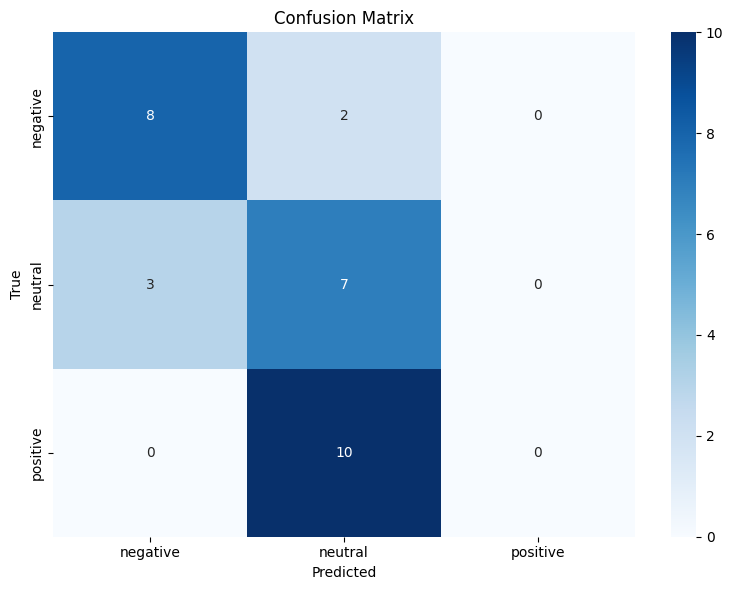

In [9]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

# Evaluate the model on the test set
model.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        test_texts, labels = batch
        test_texts, labels = test_texts.to(device), labels.to(device)

        logits, _ = model(test_texts)
        predicted_labels = logits.argmax(dim=-1).cpu().numpy()

        predictions.extend(predicted_labels)
        true_labels.extend(labels.cpu().numpy())

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Overall accuracy
overall_accuracy = accuracy_score(true_labels, predictions)
print(f"\nOverall Accuracy: {overall_accuracy * 100:.2f}%")

# Class-wise accuracy
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("\nClass-wise Accuracy:")
for i, acc in enumerate(class_accuracy):
    print(f"  Class {i} ({label_encoder.classes_[i]}): {acc * 100:.2f}%")

# Classification report
print("\nClassification Report:")
report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)
print(report)

# Print confusion matrix
ordered_labels = ['negative', 'neutral', 'positive']
ordered_indices = [list(label_encoder.classes_).index(label) for label in ordered_labels]

reordered_conf_matrix = conf_matrix[np.ix_(ordered_indices, ordered_indices)]

# Print confusion matrix
print("\nConfusion Matrix (as table):")
print("{:<10}".format(""), end="")
for label in ordered_labels:
    print("{:<10}".format(label), end="")
print()

for i, row_idx in enumerate(ordered_indices):
    row_label = ordered_labels[i]
    print("{:<10}".format(row_label), end="")
    for col_idx in ordered_indices:
        print("{:<10}".format(conf_matrix[row_idx][col_idx]), end="")
    print()


# Heatmap visualization for confusion matrix.
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
